In [5]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Creating and training model

## Train and Test data

In [6]:
# test
testDataRaw = pd.read_csv('../../../datasets/fraudTest.csv')
#print(testDataRaw.shape)
#print(testDataRaw.head())

## Visualizing Data

In [7]:
print(testDataRaw['is_fraud'].value_counts())

is_fraud
0    553574
1      2145
Name: count, dtype: int64


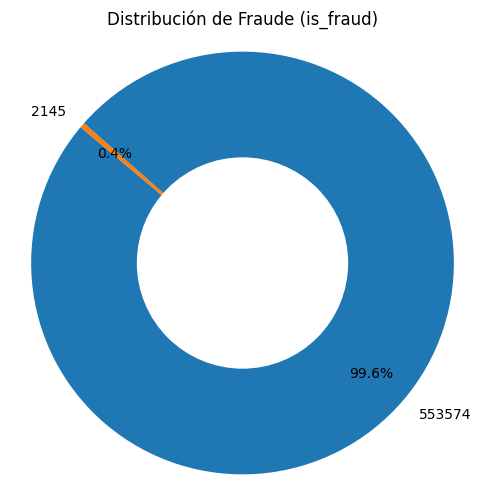

In [8]:
piecito = testDataRaw['is_fraud'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(piecito, labels=piecito, autopct='%1.1f%%', pctdistance=0.8 , startangle=140)

cir = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(cir)

plt.title('Distribución de Fraude (is_fraud)')
plt.axis('equal')

plt.show()


## Data cleaning (trainData)

In [40]:
columns_out = ['Unnamed: 0', 'cc_num', 'merchant', 'state', 'first', 'last', 'gender', 'street', 'city', 'zip', 'city', 'job', 'dob', 'trans_num', 'unix_time']

In [41]:
testData = testDataRaw.drop(columns=columns_out)

# Model Checking

In [42]:
print(testDataRaw.shape)
print(testData.shape)

(555719, 23)
(555719, 9)


In [43]:
headers = testData.columns.tolist()
print(headers)

['trans_date_trans_time', 'category', 'amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud']


In [44]:
row_data = testData.iloc[515].tolist()
print(row_data)

['2020-06-21 15:08:30', 'misc_net', 4.54, 40.4679, -77.8967, 1334, 39.800444, -77.485215, 0]


In [70]:
purchaseData = pd.DataFrame(index=[0], columns=headers)
#print(purchaseData)
purchaseData.head()

,trans_date_trans_time,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
purchaseData.loc[0] = row_data
purchaseData.head()

,trans_date_trans_time,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud
0,2020-06-21 15:08:30,misc_net,4.54,40.4679,-77.8967,1334,39.800444,-77.485215,0


In [72]:
# Guardar solo categorias en otra variable
categories = testData['category'].unique()
OH_categories = pd.DataFrame(False, index=[0], columns=[f'cat_{category}' for category in categories])

In [73]:
OH_categories.head()

,cat_personal_care,cat_health_fitness,cat_misc_pos,cat_travel,cat_kids_pets,cat_shopping_pos,cat_food_dining,cat_home,cat_entertainment,cat_shopping_net,cat_misc_net,cat_grocery_pos,cat_gas_transport,cat_grocery_net
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [74]:
X = pd.get_dummies(purchaseData, columns=['category'], prefix=['cat'])
X = X.drop(columns=['is_fraud'])

In [75]:
X.head()

,trans_date_trans_time,amt,lat,long,city_pop,merch_lat,merch_long,cat_misc_net
0,2020-06-21 15:08:30,4.54,40.4679,-77.8967,1334,39.800444,-77.485215,True


In [76]:
OH_categories.head()

,cat_personal_care,cat_health_fitness,cat_misc_pos,cat_travel,cat_kids_pets,cat_shopping_pos,cat_food_dining,cat_home,cat_entertainment,cat_shopping_net,cat_misc_net,cat_grocery_pos,cat_gas_transport,cat_grocery_net
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [77]:
columns_to_concat = X.columns.intersection(OH_categories.columns).tolist()
print(columns_to_concat)

['cat_misc_net']


In [78]:
aux_OH_categories = OH_categories
aux_OH_categories[columns_to_concat] = X[columns_to_concat]

In [79]:
aux_OH_categories.head()

,cat_personal_care,cat_health_fitness,cat_misc_pos,cat_travel,cat_kids_pets,cat_shopping_pos,cat_food_dining,cat_home,cat_entertainment,cat_shopping_net,cat_misc_net,cat_grocery_pos,cat_gas_transport,cat_grocery_net
0,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [80]:
new_X = X.drop(columns=columns_to_concat)

In [81]:
new_X.head()

,trans_date_trans_time,amt,lat,long,city_pop,merch_lat,merch_long
0,2020-06-21 15:08:30,4.54,40.4679,-77.8967,1334,39.800444,-77.485215


In [82]:
final_row = pd.concat((new_X, aux_OH_categories), axis=1)

In [83]:
final_row.head()

,trans_date_trans_time,amt,lat,long,city_pop,merch_lat,merch_long,cat_personal_care,cat_health_fitness,cat_misc_pos,...,cat_kids_pets,cat_shopping_pos,cat_food_dining,cat_home,cat_entertainment,cat_shopping_net,cat_misc_net,cat_grocery_pos,cat_gas_transport,cat_grocery_net
0,2020-06-21 15:08:30,4.54,40.4679,-77.8967,1334,39.800444,-77.485215,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [84]:
# Date encoding
final_row['hour'] = pd.to_datetime(testData['trans_date_trans_time']).dt.hour
final_row['day'] = pd.to_datetime(testData['trans_date_trans_time']).dt.day_of_week
final_row['month'] = pd.to_datetime(testData['trans_date_trans_time']).dt.month
final_row = final_row.drop(columns=['trans_date_trans_time'])
print(final_row.shape)

(1, 23)


In [85]:
final_row.head()

,amt,lat,long,city_pop,merch_lat,merch_long,cat_personal_care,cat_health_fitness,cat_misc_pos,cat_travel,...,cat_home,cat_entertainment,cat_shopping_net,cat_misc_net,cat_grocery_pos,cat_gas_transport,cat_grocery_net,hour,day,month
0,4.54,40.4679,-77.8967,1334,39.800444,-77.485215,False,False,False,False,...,False,False,False,True,False,False,False,12,6,6


In [86]:
scaler = StandardScaler()
final_row = scaler.fit_transform(final_row)
final_row = scaler.transform(final_row)

c:\Users\U S U A R I O\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [87]:
loaded_model = tf.keras.models.load_model("../v6/detectorV6.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9153 (35.75 KB)
Trainable params: 9153 (35.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
predict = loaded_model.predict(final_row)

1/1 [==============================] - 0s 53ms/step


In [65]:
predicted = (predict > 0.5).astype(float)

In [69]:
purchaseData['predicted'] = predicted
purchaseData

,trans_date_trans_time,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,predicted
0,2020-06-21 15:08:30,misc_net,4.54,40.4679,-77.8967,1334,39.800444,-77.485215,0,1.0
